# **1 - Wine Data Set**

## [Fraud in Wine](https://en.wikipedia.org/wiki/Wine_fraud)

Wine fraud relates to the commercial aspects of wine. The most prevalent type of fraud is one where wines are adulterated, usually with the addition of cheaper products (e.g. juices) and sometimes with harmful chemicals and sweeteners (compensating for color or flavor).

Counterfeiting and the relabelling of inferior and cheaper wines to more expensive brands is another common type of wine fraud.

## Project Goals

A distribution company that was recently a victim of fraud has completed an audit of various samples of wine through the use of chemical analysis on samples. The distribution company specializes in exporting extremely high quality, expensive wines, but was defrauded by a supplier who was attempting to pass off cheap, low quality wine as higher grade wine. The distribution company has hired you to attempt to create a machine learning model that can help detect low quality (a.k.a "fraud") wine samples. They want to know if it is even possible to detect such a difference.


Data Source: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

---
---

**TASK: Your overall goal is to use the wine dataset shown below to develop a machine learning model that attempts to predict if a wine is "Legit" or "Fraud" based on various chemical features.**

---
---

In [750]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [751]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science/Projects/Machine_Learning/Classification/Wine_Fraud_Prediction/wine_fraud.csv')

In [752]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


**What are the unique variables in the target column we are trying to predict (quality)?**

In [753]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

In [754]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

In [755]:
df.shape

(6497, 13)

---

# **2 - Exploratory Data Analysis**

## **A. Label Count**

**Create a countplot that displays the count per category of Legit vs Fraud. Is the label/target balanced or unbalanced?**

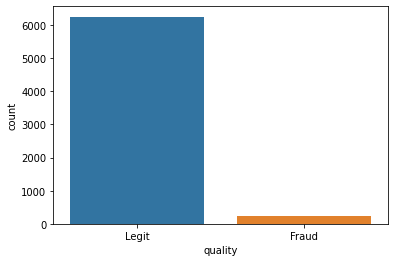

In [756]:
sns.countplot(x='quality', data=df);

In [757]:
df['quality'].value_counts()

Legit    6251
Fraud     246
Name: quality, dtype: int64

The label is unbalanced, in SVM we can alter the weight to make it balance.

**Let's find out if there is a difference between red and white wine when it comes to fraud. Create a countplot that has the wine *type* on the x axis with the hue separating columns by Fraud vs Legit.**

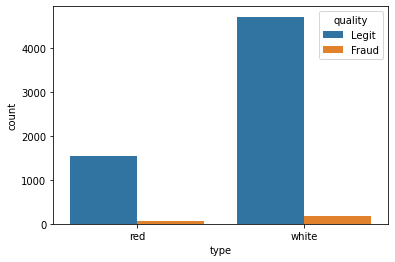

In [758]:
sns.countplot(x='type', hue='quality', data=df);

**What percentage of red wines are Fraud? What percentage of white wines are fraud?**

In [759]:
red_wine_fraud_percentage = (len(df[(df['quality'] == 'Fraud') & (df['type'] == 'red')])
                            /len(df[df['type'] == 'red']) * 100)
print(f'Percentage of fraud in Red Wines:\n{red_wine_fraud_percentage}')

Percentage of fraud in Red Wines:
3.9399624765478425


In [760]:
white_wine_fraud_percentage = (len(df[(df['quality'] == 'Fraud') & (df['type'] == 'white')])
                              /len(df[df['type'] == 'white']) * 100)
print(f'Percentage of fraud in White Wines:\n{white_wine_fraud_percentage}')

Percentage of fraud in White Wines:
3.7362188648427925


There are similar percentage of fraud in both Red and White Wines.

---

## **B. Features Correlation**

### **a. Mapping Label**

**Calculate the correlation between the various features and the "quality" column. To do this you may need to map the column to 0 and 1 instead of a string.**

In [761]:
# Create new column for quality mapping (1 if Fraud, 0 if Legit)
df['Fraud'] = df['quality'].map({'Legit':0, 'Fraud':1})

In [762]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,Fraud
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red,0


---

### **b. Correlation**

In [763]:
df.corr()['Fraud'].sort_values()

free sulfur dioxide    -0.085204
citric acid            -0.061789
alcohol                -0.051141
residual sugar         -0.048756
total sulfur dioxide   -0.035252
sulphates              -0.034046
density                 0.016351
pH                      0.020107
fixed acidity           0.021794
chlorides               0.034499
volatile acidity        0.151228
Fraud                   1.000000
Name: Fraud, dtype: float64

**Create a bar plot of the correlation values to Fraudulent wine.**

In [764]:
# Create series of features correlation
corr_ser = df.corr()['Fraud'].sort_values().drop('Fraud', axis=0)

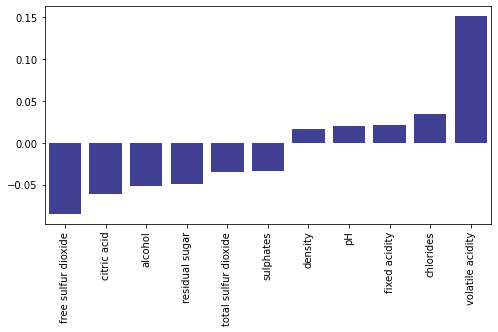

In [765]:
plt.figure(figsize=(8,4))
sns.barplot(x=corr_ser.index, y=corr_ser.values, color='darkblue', alpha=0.8)
plt.xticks(rotation=90);

---

### **c. Clustermap**

**Create a clustermap with seaborn to explore the relationships between variables.**

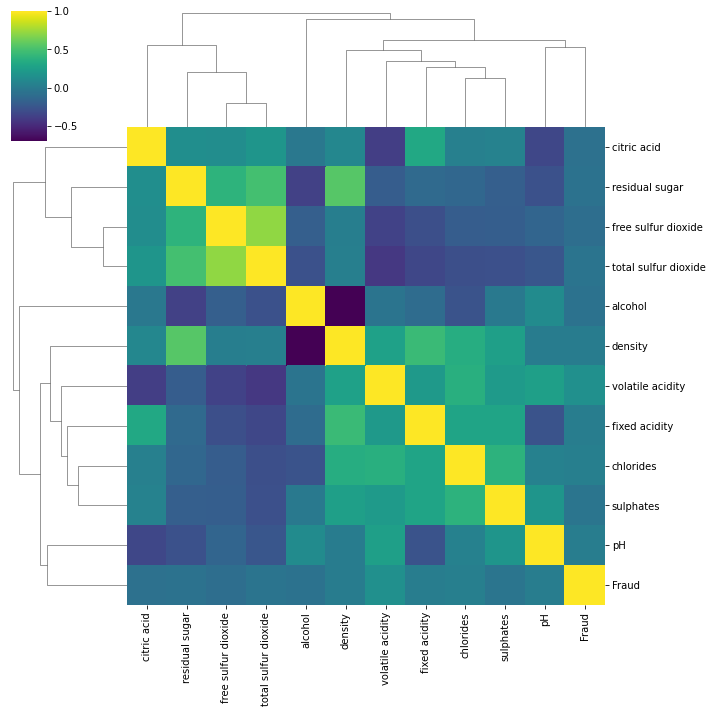

In [766]:
sns.clustermap(df.corr(), cmap='viridis');

Fraud wines tends to have higher density, ph, chlorides, fixed and volatile acidity.

---

# **3 - Support Vector Machines Classification**

## **A. Setup**



### **a. Train | Test Split**

**Convert the categorical column "type" from a string or "red" or "white" to dummy variables:**

In [767]:
df['type'] = pd.get_dummies(df['type'], drop_first=True) # 0 is red, 1 is white

In [768]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,Fraud
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,0,0


**Separate out the data into X features and y target label ("quality" column)**

In [769]:
X = df.drop(['quality','Fraud'], axis=1)
y = df['quality']

**Perform a Train|Test split on the data, with a 10% test size. Note: The solution uses a random state of 101**

In [770]:
from sklearn.model_selection import train_test_split

In [771]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [772]:
X_train.shape

(5847, 12)

In [773]:
X_test.shape

(650, 12)

---

### **b. Scaling the Data**

**Scale the X train and X test data.**

In [774]:
from sklearn.preprocessing import StandardScaler

In [775]:
scaler = StandardScaler()

In [776]:
# Fit (calculate statistical information)and Transform on train data
scaled_X_train = scaler.fit_transform(X_train)

In [777]:
scaled_X_test = scaler.transform(X_test)

---

## **B. Create Estimator/Model**



**Create an instance of a Support Vector Machine classifier. Previously we have left this model "blank", (e.g. with no parameters). However, we already know that the classes are unbalanced, in an attempt to help alleviate this issue, we can automatically adjust weights inversely proportional to class frequencies in the input data with a argument call in the SVC() call. Check out the [documentation for SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) online and look up what the argument\parameter is.**

In [778]:
from sklearn.svm import SVC 

In [779]:
# set class_weight to balanced to adjust with unbalanced label
svm = SVC(class_weight='balanced')

---

### **a. Grid Search for best Hyper-Parameters**

**Use a GridSearchCV to run a grid search for the best C and gamma parameters.**

In [780]:
from sklearn.model_selection import GridSearchCV

In [781]:
# Make the C smaller because of unbalanced dataset to make bigger bias 
# (bigger miss-clasification) toward Fraud Wine
param_grid = {'C':[0.001,0.01,0.1], 
              'kernel':['linear','rbf'], 
              'gamma':['scale','auto']
              }

In [782]:
grid_svm_model = GridSearchCV(svm, 
                              param_grid, 
                              cv=5
                              )

---

### **b. Fit/Train Model**

In [783]:
grid_svm_model.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

---

### **c. Coefficients/Parameters**

In [784]:
grid_svm_model.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [785]:
grid_svm_model.best_params_

{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

In [786]:
#grid_svm_model.cv_results_['mean_test_score']

---

## **C. Performance Evaluation**

### **a. Classification Metrics on Test Set**

**Display the confusion matrix and classification report for your model.**

In [787]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [788]:
y_pred = grid_svm_model.predict(scaled_X_test)

In [789]:
confusion_matrix(y_test, y_pred)

array([[ 19,   8],
       [116, 507]])

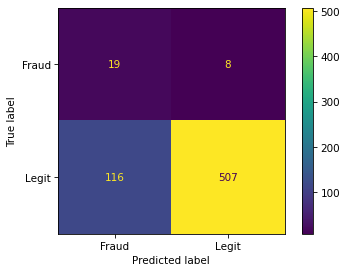

In [790]:
fig, ax = plt.subplots(figsize=(6,4), dpi=75)
plot_confusion_matrix(grid_svm_model, scaled_X_test, y_test, ax=ax, values_format='');

It is harder to interpret based on chemical features of wine because of imbalanced label, but it is good step to make another decision. In this model, be careful when the model predicted the wine as Legit.

In [791]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Fraud       0.14      0.70      0.23        27
       Legit       0.98      0.81      0.89       623

    accuracy                           0.81       650
   macro avg       0.56      0.76      0.56       650
weighted avg       0.95      0.81      0.86       650



**It is difficult to predict fraud wine based on chemical features, trying to focused on another features beyond chemicel, such as, store, wine factory, etc. Or you can try another model.**

**Precision: Ukuran seberapa banyak prediksi yang tepat**

**Recall: Ukuran seberapa banyak Nilai Aktual yang diprediksi dengan tepat**

### **b. Performance Curves**

When to Use ROC vs. Precision-Recall Curves?

Generally, the use of ROC curves and precision-recall curves are as follows:

    ROC curves should be used when there are roughly equal numbers of observations for each class.
    Precision-Recall curves should be used when there is a moderate to large class imbalance.


In [792]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

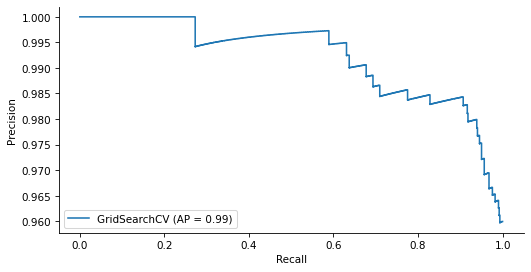

In [793]:
fig, ax = plt.subplots(figsize=(8,4), dpi=75)
plot_precision_recall_curve(grid_svm_model, scaled_X_test, y_test, ax=ax)
sns.despine() # Remove border from graph
plt.show()

---
---